In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import odeint
from scipy.integrate import solve_bvp


In [2]:
# Physical constant
e = 1.6e-19 #[C] electron charge 
M_i = 32*1.6605e-27 #[kg] ion mass
m = 9.11e-31 #[kg] electron mass
k = 1.38e-23 #[m2 kg /s2 K] Boltzmann constant

# Experimental constant
p = 10e-3*133.33 #[mTorr to Pa]
R = 30e-3 #[m] plasma half-width
L = 330e-3 #[m] chamber length
Tg = 300 #[K] gas temperature
R_0 = 2.5e-2 #[m] chosen normalization length
B_0 = 0.03 #[T] magnetic field
gamma = 20 # electron-ion temperature ratio Te/Ti
Te = 4.5 #[eV] electron temperature
Ti = Te/gamma
n_g = p/k/Tg #[m-3] neutral gas density
n_e0 = n_g * 2.75e-4 #experimental condition
alpha_0 = 1
n_n0 = alpha_0/n_e0

### 단위체크!!!

1. R은 정해진다. (이 논문에서 보고자하는게 R이 정해진 상태에서 $\alpha,n_{e0}$가 어떻게 되어야 하는지임, 거꾸로 $\alpha,n_{e0}$가 주어지면 R도 찾을수있을거같음)
2. R이 정해졌고 Boundary Condition (${\Gamma_e(R) = 0, n_e(R) = 0}$)을 만족해야한다. solve_bvp 사용할것
3. BC만족하는 Te를 찾는다. (여러개려나?)
4. Te도 나왔으니 $\nu_L$은 특정 RL값이 주어지면 결정된다.

초기 주어진값: R <br>
미지수 : E,N,U,V,W,Phi

In [11]:
def function(self, x, y):
    E = y[0]
    N = y[1]
    U = y[2]
    V = y[3]
    W = y[4]
    Phi = y[5]

    K_iz =  2.34e-15*Te**1.03*np.exp(-12.29/Te) #[m3/s]
    K_att = 1.07e-15*Te**-1.391*np.exp(-6.26/Te) #[m3/s]
    K_rec = 5.2e-14*(0.026/Ti)**0.44 #[m3/s]
    nu_i = 3.95e-16*n_g #[s-1]
    nu_e = 4.7e-14*Te**0.5*n_g #[s-1]
    nu_n = 3.95e-16*n_g #[s-1]

    w_ce = e*B_0/m
    Di = e*Ti/(M_i*nu_i)
    nu_L = 2*Di/(R*L)*(1+Te/Ti)**0.5

    G = n_g/n_e0
    Cs = np.sqrt(e*Te/M_i)
    A_i = n_e0*R_0*K_iz/Cs
    A_a = n_e0*R_0*K_att/Cs
    B_i = n_e0*R_0*K_rec/Cs
    C_i = R_0*nu_i/Cs
    C_e = R_0*nu_e/Cs
    C_n = R_0*nu_n/Cs
    Omega = R_0*w_ce/Cs 
    Epsilon_i = gamma #Te/Ti는 설정값으로줌
    Epsilon_n = gamma #Te/Tn, Ti=Tn
    Zeta = 1 #M_i/M_n, Mi=Mn
    D = R_0*nu_L/Cs
    Del = (A_i+A_a)*G+C_e
    Delta = Del*(m/M_i)*(1+Omega**2/Del**2)

    M = np.array([[V, 0, 0, E, 0, 0],
                  [U, U, (E+N), 0, 0, 0],
                  [0, W, 0, 0, N, 0],
                  [1, 0, 0, 0, 0, E],
                  [1/Epsilon_i+U**2, 1/Epsilon_i+U**2, 2*(E+N)*U, 0, 0, -(E+N)],
                  [0, Zeta/Epsilon_n+W**2, 0, 0, 2*N*W, Zeta*N]])

    RHS = np.array([(A_i-A_a)*G*E-D*(E+N),
                    A_i*G*E-B_i*(E+N)*N-D*(E+N),
                    A_a*G*E-B_i*(E+N)*N,
                    -Delta*E*V,
                    -C_i*(E+N)*U,
                    -C_n*N*W])
    result = np.linalg.solve(M,RHS)
    return result
    
def bc(self, y0, yR):
    return [0, 0]

x = np.linspace(0,R,5)
y = np.full((6,x.shape[0]), 0.0)

result = solve_bvp(function, bc, x, y, verbose=2)


[[0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01]]


TypeError: function() missing 1 required positional argument: 'y'

In [13]:
y_a = np.zeros((2, x.size))
y_a[0]

array([0., 0., 0., 0., 0.])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[3. 3. 3. 3. 3.]
 [0. 0. 0. 0. 0.]]


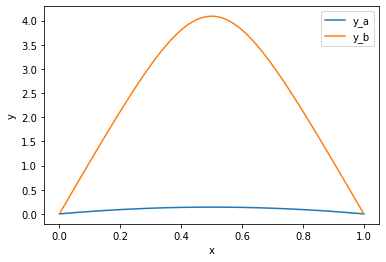

In [12]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
    
def fun(x, y):
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
    return np.array([ya[0], yb[0]])

x = np.linspace(0, 1, 5)
y_a = np.zeros((2, x.size))
y_b = np.zeros((2, x.size))
y_b[0] = 3
print(y_a)
print(y_b)
res_a = solve_bvp(fun, bc, x, y_a)
res_b = solve_bvp(fun, bc, x, y_b)

x_plot = np.linspace(0, 1, 100)
y_plot_a = res_a.sol(x_plot)[0]
y_plot_b = res_b.sol(x_plot)[0]


plt.plot(x_plot, y_plot_a, label='y_a')
plt.plot(x_plot, y_plot_b, label='y_b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
solve_bvp?

Signature:
solve_bvp(
    fun,
    bc,
    x,
    y,
    p=None,
    S=None,
    fun_jac=None,
    bc_jac=None,
    tol=0.001,
    max_nodes=1000,
    verbose=0,
    bc_tol=None,
)
Docstring:
Solve a boundary-value problem for a system of ODEs.

This function numerically solves a first order system of ODEs subject to
two-point boundary conditions::

    dy / dx = f(x, y, p) + S * y / (x - a), a <= x <= b
    bc(y(a), y(b), p) = 0

Here x is a 1-dimensional independent variable, y(x) is a n-dimensional
vector-valued function and p is a k-dimensional vector of unknown
parameters which is to be found along with y(x). For the problem to be
determined there must be n + k boundary conditions, i.e. bc must be
(n + k)-dimensional function.

The last singular term in the right-hand side of the system is optional.
It is defined by an n-by-n matrix S, such that the solution must satisfy
S y(a) = 0. This condition will be forced during iterations, so it must not
contradict boundary conditions. See